# Wine

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [5]:
from steinRF import GP, LowRankGP, MixGP
from steinRF.gp.kernels import RFF
from steinRF.gp.transforms import Transform, ARD

from steinRF.stein.srfr import srfr
# from steinRF.mar_srfr import mar_srfr
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae
from steinRF.baselines import build_svgp, build_train_svgp, svgp_predict, svgp_cross_val
from steinRF.baselines import orthogonal_gaussian
from steinRF.gp.models import *

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: cpu


## Data Preparation

In [7]:
key = jax.random.PRNGKey(0)

In [8]:
wine = pd.read_csv("wine.csv")
X, y = jnp.array(wine.iloc[:, :-1]), jnp.array(wine["quality"])
y = y.reshape(-1)
X_scaler = StandardScaler().fit(X)
X = jnp.array(X_scaler.transform(X))
y_scaler = StandardScaler().fit(y.reshape(-1, 1))
y = jnp.array(y_scaler.transform(y.reshape(-1, 1)).reshape(-1))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=int(key[0]))
X_train, X_val, y_train, y_val = jnp.array(X_train), jnp.array(X_val), jnp.array(y_train), jnp.array(y_val)

## Hyperparameter Optimization

In [18]:
# total settings
diag_min, diag_max = 1e-4, 3e-1
epoch_min, epoch_max = 500, 4000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]

# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", 5e-4, 0.1, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc

# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }
    # cv_params = {
    #     'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'alpha': alpha, 
    #     's': s, **params
    # }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ----------------------------------- NONSTATIONARY RFF ---------------------------------- #
def nrff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)

    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nrff, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MARGINAL KERNEL ----------------------------------- #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------ NONSTATIONARY STEIN MIXTURE ----------------------------- #
def nmix_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha,
        's': s, 'q': q, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nmix_rff, key, X, y, cv_params)
    return cross_val_acc


### Run Optimization

In [11]:
n_trials = 30
R = 100
q = 10
hparams = {}

#### Sparse-Variational GP

In [ ]:
# {'R': R, 'epochs': 1000, 'lr': 0.01, 'diag': 0.1}
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, diag=1e-2, from_data=False
)
hparams["svgp"] = svgp_study.best_params

#### RFF with RBF

In [ ]:
# {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000
)
hparams["rff_rbf"] = rff_rbf_study.best_params
# rff_rbf = build_rff_rbf(key, X_train, 100, 1e-2)

#### Basic RFF GP

In [ ]:
# rff = build_train_rff(
#     key, X_train, y_train, R=R, diag=0.09, lr=0.024, epochs=1000, from_data=False, init_ls=False
# )[0]
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False
)
hparams["rff"] = rff_study.best_params

#### Stein Random Features

In [19]:
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False, s=0.5
)
hparams["srf"] = srf_study.best_params

[I 2024-02-09 22:05:40,911] A new study created in memory with name: no-name-e8686d99-fc45-4df6-ba2c-2d768730db1e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-09 22:06:00,841] Trial 0 finished with value: 1.5433295589736018 and parameters: {'diag': 0.0032839775980045465, 'lr': 0.018527040254311584, 'lr_gd': 0.005253311428235241, 'alpha': 2.2}. Best is trial 0 with value: 1.5433295589736018.
[I 2024-02-09 22:06:19,880] Trial 1 finished with value: 1.0105962345927584 and parameters: {'diag': 0.0002465441387649931, 'lr': 0.10088373739580178, 'lr_gd': 0.0016379851704509034, 'alpha': 2.0}. Best is trial 1 with value: 1.0105962345927584.
[I 2024-02-09 22:06:38,820] Trial 2 finished with value: 0.9552097107689965 and parameters: {'diag': 0.00012120123964734215, 'lr': 0.19899670407313372, 'lr_gd': 0.045616901909306104, 'alpha': 1.2000000000000002}. Best is trial 2 with value: 0.9552097107689965.
[I 2024-02-09 22:06:57,869] Trial 3 finished with value: 1.085385611487149 and parameters: {'diag': 0.0225481614567996, 'lr': 0.2323091395859417, 'lr_gd': 0.037613644423428065, 'alpha': 2.4000000000000004}. Best is trial 2 with value: 0.9552097107

#### Mixture SRFR

In [26]:
# mix_rff = build_mix_rff(key, X_train, diag=1e-2, q=5, R=100, alpha=1.4, lr=0.05, from_data=False, epochs=1000)
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=75, R=R, epochs=1000, from_data=False, s=0, q=10, lr_gd=0.1
    # gd_params=lambda t: [t.kernel.transform.scale], init_ls=False
)

[I 2024-02-09 10:06:06,239] A new study created in memory with name: no-name-fec2ce51-8eda-41c9-bf9f-9f2ef9cce256


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2024-02-09 10:07:15,270] Trial 0 finished with value: 0.6522341661531357 and parameters: {'diag': 0.045001744592183375, 'lr': 0.136471296319603, 'alpha': 0.8, 'q': 4, 's': 1}. Best is trial 0 with value: 0.6522341661531357.
[I 2024-02-09 10:11:01,249] Trial 1 finished with value: 0.7365799767679951 and parameters: {'diag': 0.0001231763456339154, 'lr': 0.03790618296819413, 'alpha': 1.6, 'q': 10, 's': 1}. Best is trial 0 with value: 0.6522341661531357.
[I 2024-02-09 10:11:41,165] Trial 2 finished with value: 0.720687226558295 and parameters: {'diag': 0.021832198546095083, 'lr': 0.1692889375660587, 'alpha': 1.6, 'q': 2, 's': 0}. Best is trial 0 with value: 0.6522341661531357.
[I 2024-02-09 10:15:26,849] Trial 3 finished with value: 0.8269274537686936 and parameters: {'diag': 0.00037547715680897594, 'lr': 0.002588799759831132, 'alpha': 0.2, 'q': 10, 's': 1}. Best is trial 0 with value: 0.6522341661531357.
[I 2024-02-09 10:19:12,814] Trial 4 finished with value: 0.7781749584310028 and pa

: 

#### Nonstationary GP

In [ ]:
# build_train_nrff(key, X_train, y_train, R=100, diag=1e-4, epochs=1000, lr=0.01, from_data=False)
nrff_study = run_hyperopt(
    nrff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, from_data=False, epochs=1000
)
hparams["nrff"] = nrff_study.best_params

#### Nonstationary Mixture SRFR

In [ ]:
# build_train_nmix_rff(key, X_train, y_train, q=5, R=100, diag=1e-4, alpha=0.5, epochs=10, lr=0.01, from_data=False)
nmix_rff = run_hyperopt(
    nmix_cross_val, key, X_train, y_train, n_trials=75, R=R, from_data=False, epochs=1000,
)
hparams["nmix_rff"] = nmix_rff.best_params

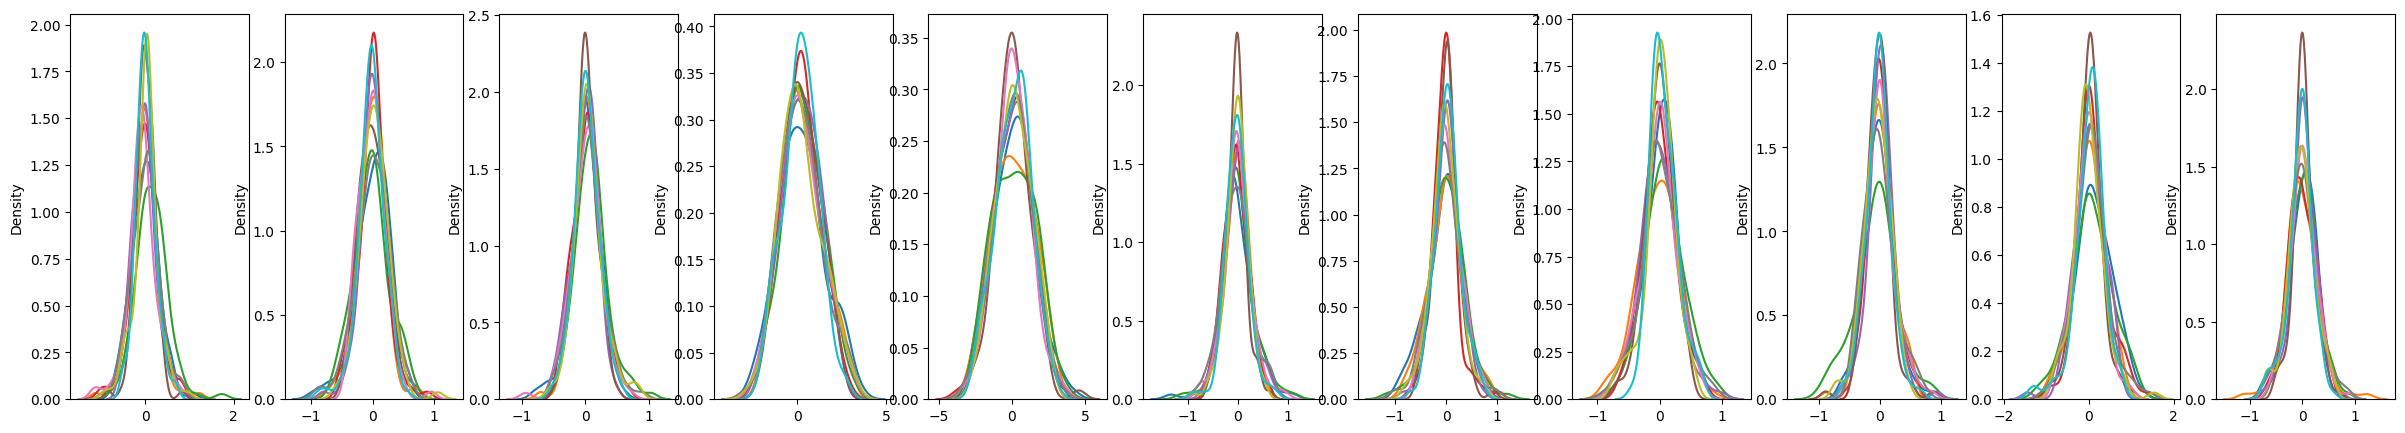

In [333]:
# fig, ax = plt.subplots(1, 11, figsize=(30, 5))

# for i in range(11):
#     for k in range(10):
#         sns.kdeplot(mix_rff.kernel.kernel.w[k, :, i], ax=ax[i])

## Define and Run Experiment

In [9]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):
    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, random_state=int(exp_key[0]))
    X_tr, X_test, y_tr, y_test = jnp.array(X_tr), jnp.array(X_test), jnp.array(y_tr), jnp.array(y_test)

    ############ ORF ############
    # orf_gp, _, _ = build_train_orf(exp_key, X_tr, y_tr, R=R, **params["orf"])
    # orf_preds, orf_sd = orf_gp.condition(y_tr, X_test)
    # orf_metrics = metric_model(y_test, orf_preds, orf_sd, scaler=scaler)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)

    # ############ NRFF ############
    # nrff_gp, _ = build_train_nrff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["nrff"])
    # nrff_preds, nrff_sd = nrff_gp.condition(y_tr, X_test)
    # nrff_metrics = metric_model(y_test, nrff_preds, nrff_sd, scaler=scaler)

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(exp_key, y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)

    # # ############ NMIX ############
    # nmix_rff_gp, _ = build_train_nmix_rff(exp_key, X_tr, y_tr, R=R, **params["nmix_rff"])
    # nmix_rff_preds, nmix_rff_sd = nmix_rff_gp.condition(exp_key, y_tr, X_test)
    # nmix_rff_metrics = metric_model(y_test, nmix_rff_preds, nmix_rff_sd, scaler=scaler)

    metrics = {
        "seed": int(exp_key[1]),
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        # "nrff": nrff_metrics,
        "mix": mix_metrics,
        # "nmix": nmix_rff_metrics
    }

    return metrics

In [10]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=5):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        run_res = experiment_run(run_keys[i], X, y, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [11]:
KEY, subkey = jax.random.split(jax.random.PRNGKey(2024))

params = {
    "svgp": {'lr': 0.012254389326799639, 'epochs': 1000, 'diag': 0.01, 'from_data': False},  # done
    "rff_rbf": {'diag': 0.08566575956727521, 'lr': 0.004409934867766953, 'epochs': 1000},  # done
    "rff": {'diag': 0.0972108582915608, 'lr': 0.024882896481772398, 'epochs': 1000, 'from_data': False},  # done
    "nrff": {'diag': 0.2780028296193103, 'lr': 0.05886320416786543, 'epochs': 1000, 'from_data': False},  # done
    "srf": {
        'diag': 0.0035583713233748263, 'lr': 0.17355927300317128, 'lr_gd': 0.2290394111784337, 'alpha': 1.8,
        'epochs': 1000, 's': 0.5, 'from_data': False
    },
    "mix_rff": {
        'diag': 0.00010206553263266048, 'lr': 0.21827956269136686, 'alpha': 1.8, 'q': 10, 's': 0,  # partially done
        'epochs': 1000, 'from_data': False, 'init_ls': True, 'lr_gd': 0.1
    },
    # "nmix_rff": {
    #     'diag': 0.005317633248648141, 'lr': 0.10784745116729445, 'alpha': 1.8, 's': 1, 'q': 10,
    #     'epochs': 1000, 'from_data': False
    # }
}

# mix_rff {'diag': 0.002848125781436113, 'lr': 0.16356905954687453, 'alpha': 0.8, 'q': 8, 's': 0.5}  0.59

In [26]:
# experiment_run(subkey, X_val, y_val, y_scaler, params, R)
res = multi_run(KEY, X, y, y_scaler, params, R=100, n_runs=10)

Running experiment 1 of 10
{'seed': 3007921430, 'svgp': Array([ 0.43316655,  0.51314334,  0.93125004, -0.02210799], dtype=float64), 'rff_rbf': Array([ 0.5494159 ,  0.58557392,  0.52500004, -0.0223774 ], dtype=float64), 'rff': Array([ 0.73478053,  0.58460133,  0.56875002, -0.02863436], dtype=float64), 'qrff': Array([ 0.4769369 ,  0.46530254,  0.67500001, -0.01592307], dtype=float64), 'srf': Array([ 0.64990352,  0.60991992,  0.1375    , -0.01726332], dtype=float64), 'mix': Array([ 0.34044488,  0.3954963 ,  0.90625   , -0.01204424], dtype=float64)}
Running experiment 2 of 10
{'seed': 2158071644, 'svgp': Array([ 0.32687764,  0.45247407,  0.97500002, -0.0053986 ], dtype=float64), 'rff_rbf': Array([0.60998084, 0.62668766, 0.46875   , 0.01411182], dtype=float64), 'rff': Array([ 0.57455204,  0.50123222,  0.64375001, -0.00540723], dtype=float64), 'qrff': Array([0.44949801, 0.43933104, 0.67500001, 0.00849778], dtype=float64), 'srf': Array([0.48821754, 0.53350634, 0.14375   , 0.0092858 ], dtype=f

In [27]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z"])
res_df.to_csv("results10.csv", index=False)

## Evaluate

In [30]:
res_df = pd.read_csv("results10.csv")

names = {
    "rff": "RFF",
    "nrff": "Nonstationary RFF",
    "rff_rbf": "RFF-RBF",
    "svgp": "Sparse VGP",
    "srf": "Stein RFF",
    "qrff": "RFF Equiv Mix Big-O",
    "mix": "Stein Mixture RFF",
    "nmix": "Nonstationary Stein Mixture RFF",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

In [32]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("rmse_mean", ascending=True).reset_index()
sum_df

,model,mse_mean,mse_std,mae_mean,mae_std,cal_mean,cal_std,z_mean,z_std,rmse_mean,rmse_std,log_mse_mean,log_mse_std
0,Stein Mixture RFF,0.375485,0.060188,0.420104,0.033608,0.894375,0.031243,0.002246,0.008494,0.611138,0.047084,-0.989930,0.148093
1,Sparse VGP,0.408802,0.062843,0.499693,0.034581,0.944375,0.025422,-0.001913,0.011046,0.637724,0.048418,-0.904797,0.149892
2,RFF Equiv Mix Big-O,0.497939,0.085768,0.482266,0.057787,0.669375,0.050385,-0.001053,0.006410,0.703191,0.062011,-0.711467,0.180483
3,Stein RFF,0.606677,0.090511,0.579950,0.041430,0.131875,0.017040,0.003837,0.009341,0.776875,0.059088,-0.510286,0.154946
4,RFF-RBF,0.654599,0.081107,0.639075,0.040690,0.479375,0.038194,-0.001077,0.011501,0.807673,0.050148,-0.430671,0.124320
5,RFF,0.705901,0.106851,0.576974,0.051697,0.580625,0.036616,0.000413,0.013161,0.837993,0.063850,-0.358747,0.153052


Text(0.5, 1.0, 'Wine UCI Dataset Error')

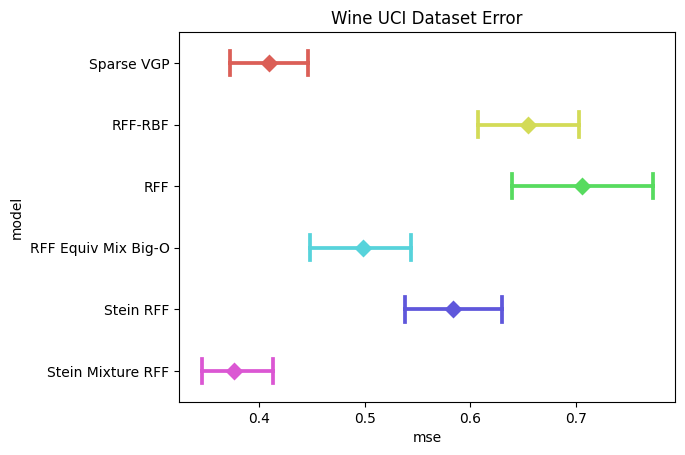

In [16]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="log_mse", y="model", hue="model",
    errorbar="ci", capsize=.4,
    palette=colors, legend=False,
    color=".5", linestyle="none", marker="D",
)
pointplot.set_title("Wine UCI Dataset Error")

### Learned Kernels

In [165]:
mkey = jax.random.PRNGKey(42)
plot_key, plot_subkey = jax.random.split(mkey)

#### RFF GP
build_rff_prms = deepcopy(params["rff"])
build_rff_prms.pop("lr")
build_rff_prms.pop("epochs")
rff_gp = build_rff(mkey, X_train, R=100, **build_rff_prms)
rff_gp = eqx.tree_deserialise_leaves('rff_gp.eqx', rff_gp)

rff_preds, rff_sd = rff_gp.condition(y_train, X_val)
rff_metrics = metric_model(y_val, rff_preds, rff_sd, scaler=y_scaler)

#### Mixture GP
# mix_gp, _ = build_train_mix_rff(mkey, X_train, y_train, R=100, restarts=1, **params["mix_rff"])
build_mix_rff_prms = deepcopy(params["mix_rff"])
build_mix_rff_prms.pop("lr")
build_mix_rff_prms.pop("lr_gd")
build_mix_rff_prms.pop("alpha")
build_mix_rff_prms.pop("s")
build_mix_rff_prms.pop("epochs")
mix_gp = build_mix_rff(mkey, X_train, R=100, **build_mix_rff_prms)
mix_gp = eqx.tree_deserialise_leaves('mix_gp.eqx', mix_gp)

mix_preds, mix_sd = mix_gp.condition(mkey, y_train, X_val)
mix_metrics = metric_model(y_val, mix_preds, mix_sd, scaler=y_scaler)

# sample
mix_gp_mus, mix_gp_sds = mix_gp.multi_condition(y_train, X_val, mix_gp._diag)
dists = tfd.MultivariateNormalDiag(mix_gp_mus, mix_gp_sds)
mixgp_samples = dists.sample(100, seed=key)

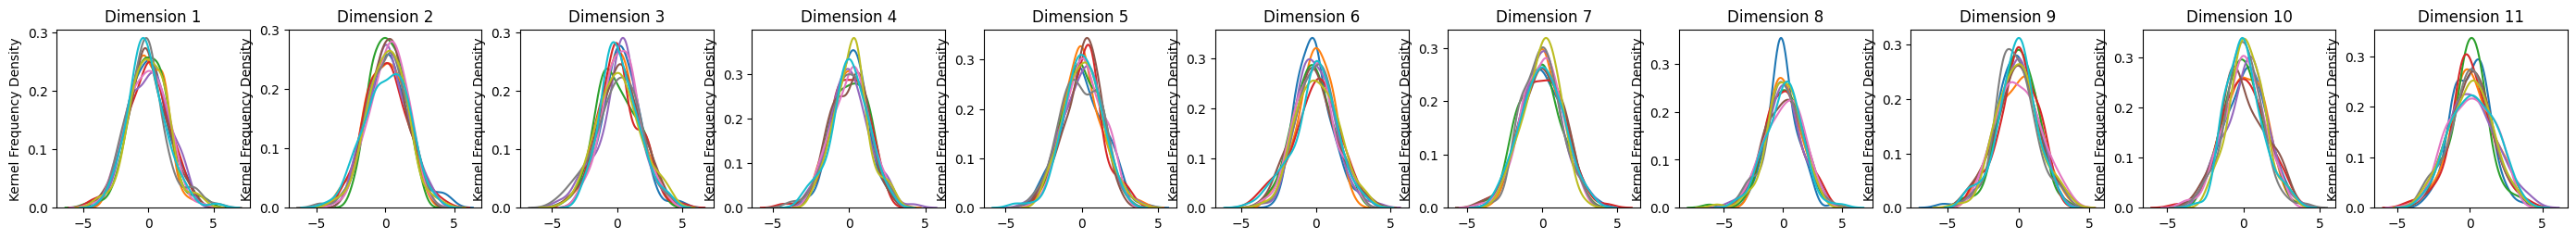

In [166]:
k_dims = jnp.asarray(mix_gp.kernel.kernel.w.shape)
M, d = int(k_dims[0]), int(k_dims[2])

fig, ax = plt.subplots(1, d, figsize=(35, 2.5))

# w_plot = mix_gp.kernel.transform(mix_gp.kernel.kernel.w)
w_plot = mix_gp.kernel.kernel.w

for _d in range(d):
    for _m in range(M):
        sns.kdeplot(w_plot[_m, :, _d], ax=ax[_d]) 
        ax[_d].set_title(f"Dimension {_d + 1}")
        ax[_d].set_ylabel("Kernel Frequency Density")

plt.show()
fig.savefig("m-srfr_kernel.pdf", format="pdf", bbox_inches="tight")

In [201]:
def dist_vals(mu, sd, n_samples=1000):
    bounds = (mu - 3 * sd, mu + 3 * sd)
    _X = jnp.linspace(bounds[0], bounds[1], n_samples)
    dist = tfd.Normal(mu, sd)

    mode_val = dist.prob(mu)
    pdf_vals = dist.prob(_X) / mode_val

    return _X, pdf_vals


def plot_preds(rff_mu, rff_sd, mix_mus_m, mix_sds_m, mix_preds, mix_sds, y, ax=None, i=0):
    # rff predictions
    X_rff, p_rff = dist_vals(rff_mu[i], rff_sd[i])
    sns.lineplot(x=X_rff, y=p_rff, label="RFF GP", color="blue", ax=ax)

    # mix gp predictions (mean)
    X_mix, p_mix = dist_vals(mix_preds[i], mix_sds[i])
    sns.lineplot(x=X_mix, y=p_mix, label="Mixture GP (mean)", color="red", linestyle="--", ax=ax)

    # mix gp preds (mixture components)
    m = mix_mus_m.shape[0]
    for _m in range(m):
        X_mix_m, p_mix_m = dist_vals(mix_mus_m[_m, i], mix_sds_m[_m, i])
        sns.lineplot(x=X_mix_m, y=p_mix_m, color="red", alpha=0.2, ax=ax)  # label=f'Mixture {_m}'

    # true value
    plt.vlines(y[i], 0, 1, linestyle="--", label="True Value", color="black")
    plt.legend()

    plt.show()

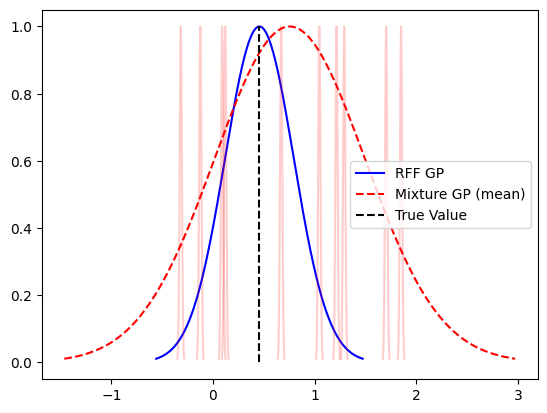

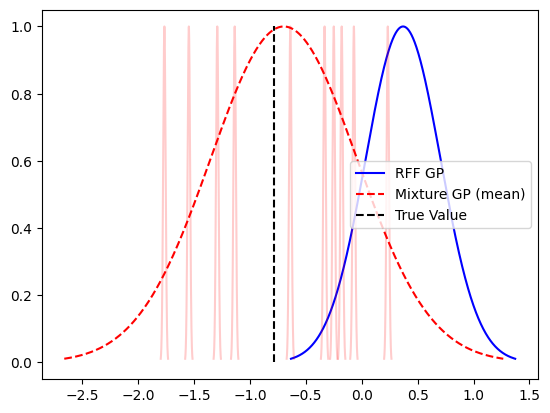

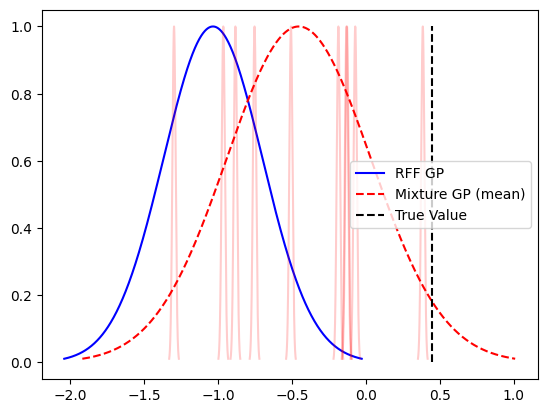

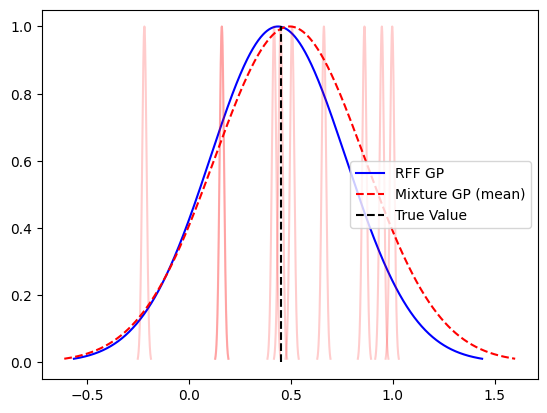

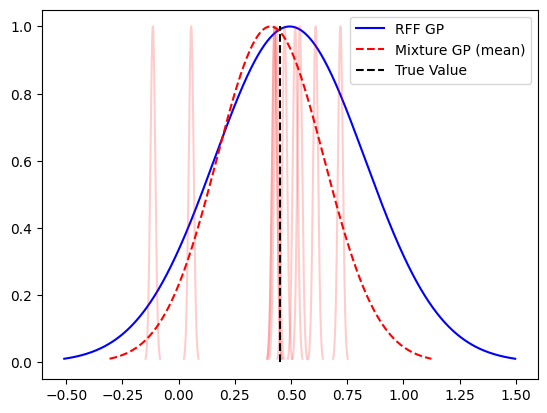

In [208]:
plot_key, plot_subkey = jax.random.split(plot_key)

n_plots = 5
y_samples = jax.random.choice(plot_subkey, jnp.arange(y_val.shape[0]), shape=(n_plots,)).tolist()

# fig, ax = plt.subplots(1, n_plots, figsize=(n_plots * 5, 5))
for j in range(n_plots):
    plot_preds(rff_preds, rff_sd, mix_gp_mus, mix_gp_sds, mix_preds, mix_sd, y_val, i=y_samples[j])
plt.show()
# plot_preds(rff_preds, rff_sd, mix_gp_mus, mix_gp_sds, mix_preds, mix_sd, y_val, ax=ax, i=20)

In [173]:
mix_gp_mus[:, 20]

Array([ 2.11485458,  0.25271039,  0.70722281,  0.86145877, -0.32626685,
        0.29918426,  0.58156959,  1.08777425,  0.94844905,  0.89124104],      dtype=float64)

In [174]:
mix_gp_sds[:, 20]

Array([0.01095462, 0.01092568, 0.01088778, 0.01099631, 0.01093227,
       0.01090874, 0.01098191, 0.01091375, 0.01090761, 0.01095499],      dtype=float64)

In [74]:
mix_gp_mus.shape

(10, 160)